In [8]:
import pandas as pd
import numpy as np
import talib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('Mastercard_stock_history.csv')

In [10]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.00,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.00,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.00,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.00,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.00,0.0
...,...,...,...,...,...,...,...,...
3867,2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100,0.00,0.0
3868,2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000,0.00,0.0
3869,2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200,0.44,0.0
3870,2021-10-08,356.000000,360.369995,354.209991,354.959991,2336700,0.00,0.0


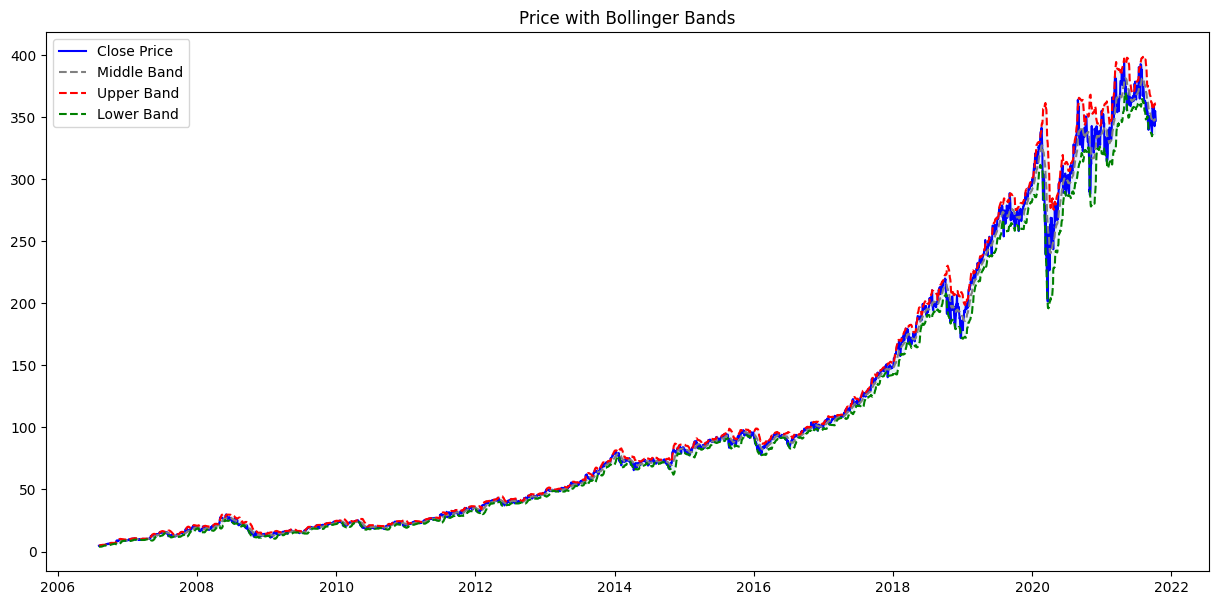

In [11]:


df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Percentage change
df['Daily_Return'] = df['Close'].pct_change()

"""
    - This is a pandas function that calculates the **percentage change** between the current element and the previous one in a column or Series.
"""

# Moving Average
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

"""
- df['MA20']: Computes the **20-day moving average** of the `'Close'` column (average of the most recent 20 closing prices for each row).
- df['MA50']: Computes the **50-day moving average** of the `'Close'` column (average of the most recent 50 closing prices for each row).
"""


# Bollinger Bands
df['BB_middle'] = df['Close'].rolling(window=20).mean()
df['BB_upper'] = df['BB_middle'] + 2 * df['Close'].rolling(window=20).std()
df['BB_lower'] = df['BB_middle'] - 2 * df['Close'].rolling(window=20).std()

df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']  # Bollinger Band genişliği
df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])  # Fiyatın bantlar arasındaki pozisyonu

"""

Orta Bant (Middle Band):

20 günlük basit hareketli ortalama (SMA) kullanılır
Trendin yönünü belirlemede yardımcı olur


Üst ve Alt Bantlar:

Orta banda +/- 2 standart sapma eklenerek oluşturulur
Fiyat oynaklığını (volatilite) gösterir
Üst bant = 20 günlük SMA + (2 × standart sapma)
Alt bant = 20 günlük SMA - (2 × standart sapma)
"""

# Date düzenlemeleri
df['DayOfYear'] = df.index.dayofyear
df['DayOfWeek'] = df.index.dayofweek
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df['quarter'] = df.index.quarter


# Sinüs/cosinüs dönüşümleri
df['Year_Sin'] = np.sin(2 * np.pi * df['DayOfYear']/365)
df['Year_Cos'] = np.cos(2 * np.pi * df['DayOfYear']/365)

df['Week_Sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
df['Week_Cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

"""
Bu dönüşümler dairesel bir yaklaşım yapılabilmeye yarar.
"""

# Teknik göstergeler
df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

"""
20 günlük günlük getirilerin standart sapmasını hesaplar
np.sqrt(252) ile yıllık volatiliteye dönüştürülür (252 = bir yıldaki işlem günü sayısı)
Yüksek volatilite yüksek riski, düşük volatilite düşük riski gösterir
"""


df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

"""
14 günlük periyot için fiyatın momentumunu ölçer
0-100 arasında değer alır
70 üstü aşırı alım, 30 altı aşırı satım bölgesi olarak kabul edilir
Trend dönüşlerini tespit etmede kullanılır
"""

df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

"""
MACD çizgisi: 12 ve 26 günlük hareketli ortalamaların farkı
Sinyal çizgisi: MACD'nin 9 günlük hareketli ortalaması
Histogram: MACD ve sinyal çizgisi arasındaki fark
"""


# Lag değerleri 
lag_features = ['Close', 'Volume', 'Daily_Return', 'RSI', 'Volatility', 'BB_width', 'BB_position']
lag_periods = [1, 2, 3, 5]

for feature in lag_features:
    for lag in lag_periods:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# Fiyat değişim oranları
for lag in lag_periods:
    df[f'price_change_{lag}d'] = df['Close'].pct_change(periods=lag)

# Momentum özellikleri
for lag in lag_periods:
    df[f'momentum_{lag}d'] = df['Close'] - df[f'Close_lag_{lag}']

# Bollinger Bands bazlı trading sinyalleri
df['BB_breakout_up'] = (df['Close'] > df['BB_upper']).astype(int)
df['BB_breakout_down'] = (df['Close'] < df['BB_lower']).astype(int)
df['BB_trending'] = ((df['BB_width'] > df['BB_width'].rolling(window=20).mean())).astype(int)

# Eksik değerleri kaldır
df.dropna(inplace=True)

# Yuvarlama işlemi için numeric_columns güncelleme
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Daily_Return', 'MA20', 'MA50',
                  'Volatility', 'Year_Sin', 'Year_Cos', 'Week_Sin', 'Week_Cos',
                  'BB_middle', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position']

# Lag kolonlarını numeric_columns'a ekle
for feature in lag_features:
    for lag in lag_periods:
        numeric_columns.append(f'{feature}_lag_{lag}')
for lag in lag_periods:
    numeric_columns.extend([f'price_change_{lag}d', f'momentum_{lag}d'])

df[numeric_columns] = df[numeric_columns].round(4)



plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['BB_middle'], label='Middle Band', color='gray', linestyle='--')
plt.plot(df.index, df['BB_upper'], label='Upper Band', color='red', linestyle='--')
plt.plot(df.index, df['BB_lower'], label='Lower Band', color='green', linestyle='--')
plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.1)
plt.title('Price with Bollinger Bands')
plt.legend()
plt.show()

In [12]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,MA20,MA50,...,price_change_2d,price_change_3d,price_change_5d,momentum_1d,momentum_2d,momentum_3d,momentum_5d,BB_breakout_up,BB_breakout_down,BB_trending
Date,,,,,,,,,,,,,,,,,,,,,
2006-08-04,4.6792,4.7909,4.6504,4.6560,14216000,0.00,0.0,0.0012,4.2912,4.3143,...,0.0006,0.1122,0.0810,0.0056,0.0028,0.4698,0.3488,1,0,1
2006-08-07,4.6978,4.7723,4.6746,4.7537,6918000,0.00,0.0,0.0210,4.3126,4.3237,...,0.0222,0.0216,0.1140,0.0977,0.1033,0.1005,0.4865,1,0,1
2006-08-08,4.7537,4.8997,4.7490,4.8904,14073000,0.00,0.0,0.0288,4.3415,4.3380,...,0.0503,0.0516,0.1682,0.1367,0.2344,0.2400,0.7042,1,0,1
2006-08-09,4.9304,5.0699,4.8374,4.9164,15043000,0.00,0.0,0.0053,4.3755,4.3544,...,0.0342,0.0559,0.0566,0.0260,0.1628,0.2605,0.2633,0,0,1
2006-08-10,4.8560,5.0151,4.8467,4.9825,8725000,0.00,0.0,0.0134,4.4166,4.3705,...,0.0188,0.0481,0.0714,0.0660,0.0921,0.2288,0.3321,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-05,347.1214,348.1301,342.4972,342.7769,4724100,0.00,0.0,-0.0029,347.8944,356.8603,...,-0.0471,-0.0129,-0.0227,-0.9888,-16.9486,-4.4644,-7.9600,0,0,0
2021-10-06,339.5810,348.4398,338.6821,348.2500,3712000,0.00,0.0,0.0160,347.7771,356.0298,...,0.0130,-0.0319,-0.0127,5.4731,4.4843,-11.4755,-4.4943,0,0,0
2021-10-07,349.0000,357.9000,349.0000,353.9100,3209200,0.44,0.0,0.0163,347.9243,355.4488,...,0.0325,0.0295,0.0192,5.6600,11.1331,10.1443,6.6687,0,0,1


In [13]:
# Select features
features = [
    # Temel fiyat ve hacim özellikleri
    'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return',

    # Hareketli ortalamalar ve volatilite
    #'MA20', 'MA50', 'Volatility',

    # Bollinger Bands özellikleri
    #'BB_middle', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position',
    #'BB_breakout_up', 'BB_breakout_down', 'BB_trending',

    # RSI ve MACD
    #'RSI', 'MACD', 'MACD_signal', 'MACD_hist',

    # Zaman bazlı sinüs/cosinüs dönüşümleri
    #'Year_Sin', 'Year_Cos', 'Week_Sin', 'Week_Cos',

    # Tarih özellikleri
    #'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter',

    # Lag özellikleri
    'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5',
    'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_5',
    'Daily_Return_lag_1', 'Daily_Return_lag_2', 'Daily_Return_lag_3', 'Daily_Return_lag_5',
    'RSI_lag_1', 'RSI_lag_2', 'RSI_lag_3', 'RSI_lag_5',
    'Volatility_lag_1', 'Volatility_lag_2', 'Volatility_lag_3', 'Volatility_lag_5',

    # Fiyat değişim oranları
    'price_change_1d', 'price_change_2d', 'price_change_3d', 'price_change_5d',

    # Momentum özellikleri
    'momentum_1d', 'momentum_2d', 'momentum_3d', 'momentum_5d'
]


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1893e-05
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9870e-05
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5342e-05
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9245e-05
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3385e-05
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9702e-05
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8500e-05
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8506e-05
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8501e-05
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8790e-05
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7699e-05
Epoch 13/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6413e-05
Epoch 14/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5390e-05
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

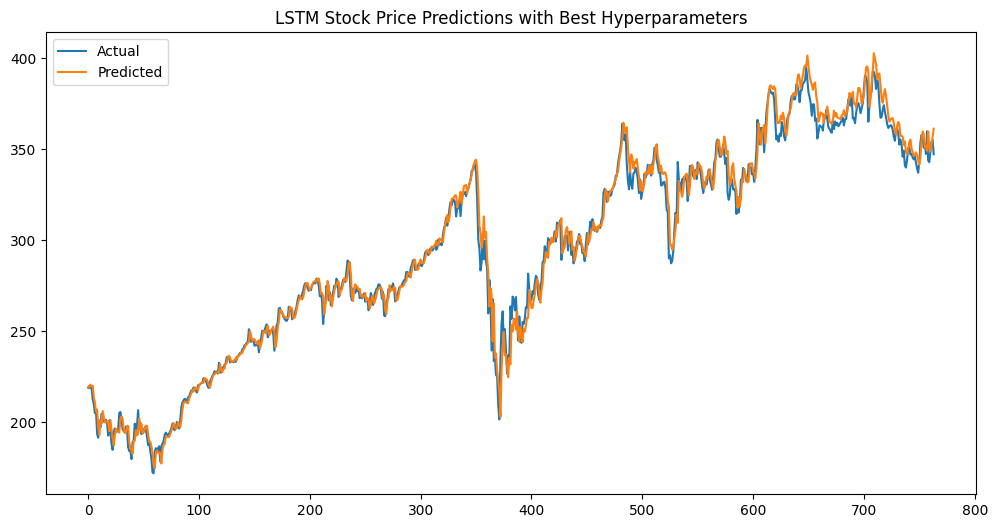

RMSE: 7.13
MAE: 4.90
MAPE: 1.68%


In [15]:

def set_seeds(seed_value=42):
    """Set seeds for reproducibility"""
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seeds(42)

data = df[features].values

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])  # Index 3 is Close price
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

# Compile the model with the best learning rate
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Predict
y_pred = model.predict(X_test)

# Prepare close price scaler
close_price_scaler = MinMaxScaler()
close_price_scaler.fit(df['Close'].values.reshape(-1, 1))

# Inverse transform
y_test_inv = close_price_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = close_price_scaler.inverse_transform(y_pred)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('LSTM Stock Price Predictions with Best Hyperparameters')
plt.show()

rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv) ** 2))
mae = np.mean(np.abs(y_test_inv - y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
#Best model based on MAPE: Base+Lag+PriceChange+Momentum


## Devamında yapılabilecekler

1- Feature selection (data detaylı)

2- Cross validation

3- indikatörlerin zaman farklı seçimleri

4- sequence_length seçimi

4- LSTM alternatifi algoritmalar